# Dự báo bán của hà nội theo từng sản phẩm theo tuần 
#### Amazon Forecast API 
---
Các bước thực hiện của Amazon Forecast như sau:

1. Tạo một **Dataset Group**.
2. Tạo **Dataset** để dự báo Có 3 loại dataset là *Target Time Series*, *Related Time Series* và *Item Metadata*.*Target Time* là bắt buộc.
3. **Import data**, đây là bước nhập tập dữ liệu được lấy từ S3 để xử lý và  dự báo.
4. **Train Model**, đây là bước xác định các giá trị hiệu quả nhất của dữ liệu .
5. **Deploy a Predictor**, đây là bước để triển khai mô hình để chạy dự báo.
6. **Query the Forecast**, đưa ra dự báo của một id bất kỳ trong một khoảng thời gian và xem kết quả của mô hình

## Table Of Contents
* **Các bước chuẩn bị**
    * Cài đặt
    * Xử lý Dữ liệu
    * Tạo Dataset Group và Dataset
* **Xây dựng mô hình dự báo**
    * Tạo mô hình
    * Triển khai mô hình
* **Kiểm tra mô hình dự báo**
    * Xuất dữ liệu
    * Kiểm tra kết quả phỏng đoán
    * So sánh dữ liệu phỏng đoán với dữ liệu
Nếu muốn biết thêm về Amazon Forecast đọc thêm [documentation](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)

# Các bước chuẩn bị
---
# IAM role and authorizations
Đảm bảo Sage Maker được cấp quyền các quyền sử dụng sau
* IAMFullAccess
* AmazonForecastFullAccess
* AmazonS3FullAccess
* AmazonSageMakerFullAccess

Bạn có thể vào IAM Console và kiểm tra quyền của SageMaker được cấp quyền như sau :

![Dataset](picture/roles.png)

và kiểm tra liên kết 

![Dataset](picture/relationship.png)


# Cài đặt

Thêm vào một số thư viên tiêu chuẩn để sử dụng cho notebook này

In [94]:
import boto3
import botocore.exceptions
import dateutil.parser
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker
import sys
import time

from datetime import datetime
from sagemaker import get_execution_role

%matplotlib inline
plt.style.use('Solarize_Light2')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Trước tiên chúng ta phải chỉnh S3 bucket name và tên vùng cho notebook:
* Nếu chưa có S3 bucket, tạo S3 và  đảm bảo được liên kết với notebook
* Chọn vùng : eu-west-1 là cố định

In [27]:
BUCKET = sagemaker.Session().default_bucket()
PREFIX = 'Hanoi_retail'
region = 'eu-west-1'

session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')
role = get_execution_role()

In [28]:
# Paths to local data:
DATA = 'data'
PROCESSED_DATA = 'data/processed'

os.makedirs(PROCESSED_DATA, exist_ok=True)

# Xử lý dữ liệu
Đầu tiên sử dụng Pandas để đọc file CSV, lưu vào hourly_df để đọc và chuẩn bị để đưa vào dự báo và xuất ra màn hình một số dữ liệu

In [29]:
hourly_df = pd.read_csv(os.path.join(DATA, 'forecast.csv'), header=None, parse_dates=[0])
hourly_df.columns = ['timestamp','item_id','qty']
hourly_df.head()

,timestamp,item_id,qty
0,2019-01-01,271554,2
1,2019-01-01,495366,1
2,2019-01-02,495360,1
3,2019-01-03,525764,165
4,2019-01-05,517242,1


Dữ liệu đưa vào phải đảm bảo đủ 3 yêu cầu của Amazon Forecast
1. The Timestamp (timestamp)
2. A Value (qty)
3. An item (item_id)

In [30]:
print(np.min(hourly_df['timestamp']))
print(np.max(hourly_df['timestamp']))

2019-01-01 00:00:00
2019-12-31 00:00:00


Dự liệu xét từ ngày 1 tháng 1 năm 2019 đến ngày 31 tháng 12 năm 2019.Ta cắt ra xét từ ngày 1 tháng 1 đến 28 tháng 7 làm bộ để huấn luyện.

* Training test: 01-01-2019
* Training end : 28-07-2019
* Testing start : 29-07-2019
* Testing end : 31-12-2019

Lưu dữ liệu vào hai file csv để dự báo

In [31]:
training_start = pd.to_datetime('2019-01-01')
training_end   = pd.to_datetime('2019-07-28')
testing_start  = pd.to_datetime('2019-07-29')
testing_end    = pd.to_datetime('2019-12-31')

In [32]:
hourly_df

,timestamp,item_id,qty
0,2019-01-01,271554,2
1,2019-01-01,495366,1
2,2019-01-02,495360,1
3,2019-01-03,525764,165
4,2019-01-05,517242,1
...,...,...,...
15013,2019-12-15,271554,1
15014,2019-12-17,395581,1
15015,2019-12-24,271554,1
15016,2019-12-25,269765,1


In [33]:
training_df = hourly_df[(hourly_df['timestamp'] >=training_start) & (hourly_df['timestamp'] < training_end)]
testing_df= hourly_df[(hourly_df['timestamp'] >=testing_start) & (hourly_df['timestamp'] < testing_end)]

In [34]:
training_df.to_csv(f"{PROCESSED_DATA}/train.csv", header=False, index=False)
testing_df.to_csv(f"{PROCESSED_DATA}/test.csv", header=False, index=False)

In [35]:

!ls -lh $PROCESSED_DATA/

total 296K
-rw-rw-r-- 1 ec2-user ec2-user  54K May 14 13:19 test.csv
-rw-rw-r-- 1 ec2-user ec2-user 239K May 14 13:19 train.csv


Đẩy dữ liệu cần huấn luyện lên S3 để thực hiện dự báo

In [36]:
KEY = f'{PREFIX}/train.csv'
boto3.Session().resource('s3').Bucket(BUCKET).Object(KEY).upload_file(f'{PROCESSED_DATA}/train.csv')

# Tạo Dataset Group và Dataset

In [37]:
DATASET_FREQUENCY = "D" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [38]:
project = 'Hanoi_retail_forecast'
datasetName = project + '_ds'
datasetGroupName = project + '_dsg'
s3DataPath = "s3://" + BUCKET + "/" + KEY

# Tạo Dataset Group

In [ ]:
%%time

# Let's try to create a dataset group:
try:
    create_dataset_group_response = forecast.create_dataset_group(
        DatasetGroupName=datasetGroupName,
        Domain="CUSTOM",
    )
    datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']
    
    # If the dataset group already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A dataset group with this name already exists, you can use it to create and ingest new datasets')
        
        # List all the existing dataset groups:
        forecast_dsg_list = forecast.list_dataset_groups()

        # Loop through all the Forecast dataset groups:
        for dsg in forecast_dsg_list['DatasetGroups']:
            # Get the project name (the string after the first delimiter in the ARN)
            dsg_name = dsg['DatasetGroupArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (dsg_name == datasetGroupName):
                datasetGroupArn = dsg['DatasetGroupArn']
                break
                
    else:
        raise
        
print(f'- Dataset group name: {datasetGroupName}')
print(f'- Dataset group ARN: {datasetGroupArn}')

Sau khi tạo thành công chúng ta kiểm tra trên console thấy hiện như ảnh thì tạo dataset group thành công
![Dataset](picture/datasetgroup.png)

In [40]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'Hanoi_retail_forecast_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:eu-west-1:800285456211:dataset-group/Hanoi_retail_forecast_dsg',
 'DatasetArns': ['arn:aws:forecast:eu-west-1:800285456211:dataset/Hanoi_retail_forecast_ds'],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 5, 12, 14, 27, 14, 921000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 5, 12, 14, 53, 16, 266000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'f67ea793-9387-48d2-9fd9-d32427820894',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 14 May 2021 13:19:08 GMT',
   'x-amzn-requestid': 'f67ea793-9387-48d2-9fd9-d32427820894',
   'content-length': '347',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Tạo Dataset

In [41]:
schema = {
   "Attributes": [
      { "AttributeName": "timestamp",    "AttributeType": "timestamp" },
      { "AttributeName": "item_id",      "AttributeType": "string"    },
        { "AttributeName": "target_value", "AttributeType": "float"     }
   ]
}

In [42]:
training_df.head()

,timestamp,item_id,qty
0,2019-01-01,271554,2
1,2019-01-01,495366,1
2,2019-01-02,495360,1
3,2019-01-03,525764,165
4,2019-01-05,517242,1


Chúng ta cần chú ý tạo lược đồ đúng với dữ liệu đầu vào như target_value là qty và item_id là item_id trong dữ liệu .

In [ ]:
## %%time 

try:
    response = forecast.create_dataset(
        Domain='CUSTOM',
        DatasetType='TARGET_TIME_SERIES',
        DatasetName=datasetName,
        DataFrequency=DATASET_FREQUENCY, 
        Schema=schema
    )
    datasetArn = response['DatasetArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the dataset group already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A dataset with this name already exists, you can use it to ingest new data into it:')
        
        # List all the existing datasets:
        forecast_ds_list = forecast.list_datasets()

        # Loop through all the Forecast datasets:
        for ds in forecast_ds_list['Datasets']:
            # Get the project name (the string after the first delimiter in the ARN)
            ds_name = ds['DatasetArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (ds_name == datasetName):
                datasetArn = ds['DatasetArn']
                break
                
    else:
        raise
        
print(f'- Dataset name: {datasetName}')
print(f'- Dataset ARN: {datasetArn}')

In [44]:
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:eu-west-1:800285456211:dataset/Hanoi_retail_forecast_ds',
 'DatasetName': 'Hanoi_retail_forecast_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'D',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 5, 12, 14, 28, 1, 132000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 5, 12, 14, 48, 11, 535000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'd06636da-4fc6-4c5f-97d6-b3683678f38f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 14 May 2021 13:19:09 GMT',
   'x-amzn-requestid': 'd06636da-4fc6-4c5f-97d6-b3683678f38f',
   'content-length': '509',
   'connection': 'keep-alive'},
  'Ret

# Thêm Dataset vào Dataset Group

In [45]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '11036e2f-6563-4f13-b66c-2d4fa2af33c0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 14 May 2021 13:19:10 GMT',
   'x-amzn-requestid': '11036e2f-6563-4f13-b66c-2d4fa2af33c0',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Sau khi thêm thành công kiểm tra trên console nếu active là thêm Dataset vào Dataset Group thành công sẽ hiện như hình dưới đây:
![Dataset](picture/adddataset.png)

In [46]:
def get_or_create_iam_role(role_name):
    iam = boto3.client("iam")

    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
              "Effect": "Allow",
              "Principal": {
                "Service": "forecast.amazonaws.com"
              },
              "Action": "sts:AssumeRole"
            }
        ]
    }

    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
        )
        role_arn = create_role_response["Role"]["Arn"]
        print("Created", role_arn)
        
    except iam.exceptions.EntityAlreadyExistsException:
        print("The role " + role_name + " exists, ignore to create it")
        role_arn = boto3.resource('iam').Role(role_name).arn

    print("Attaching policies")

    iam.attach_role_policy(
        RoleName = role_name,
        PolicyArn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
    )

    iam.attach_role_policy(
        RoleName=role_name,
        PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    )

    print("Waiting for a minute to allow IAM role policy attachment to propagate")
    time.sleep(60)

    print("Done.")
    return role_arn

In [47]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebook-RetailPrediction"
role_arn = get_or_create_iam_role(role_name=role_name)

The role ForecastNotebook-RetailPrediction exists, ignore to create it
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.


# Tạo Data Import Job
Sau khi mô hình dự báo đã hiểu được định dạng file CSV, bước tiếp theo chúng ta đẩy dữ liệu từ S3 lên Amazon Forecast.

In [ ]:
datasetImportJobName = 'Hanoi_retail_dataset_import_job'
ds_import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=datasetImportJobName,
    DatasetArn=datasetArn,
    DataSource= {
        "S3Config" : {
            "Path": s3DataPath,
            "RoleArn": role_arn
        }
    },
    TimestampFormat=TIMESTAMP_FORMAT
)

In [ ]:
while True:
    status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(str(pd.to_datetime(datetime.now()))[:19], "| Data ingestion:", status)
    
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(60)

print(status)

Sau khi đẩy thành dữ liệu thành Amazon Forecast thành công như trong ảnh, bước tiếp theo dựng mô hình dự báo.
![Dataset](picture/import_job.png)

# Xây dựng mô hình dự báo
---
# Tạo mô hình

Đây là bước Sau khi đẩy dữ liệu lên Amazon Forecast thành công tiếp theo đó chúng ta xây dựng mô hình phù hợp với yêu cầu.

Forecast Horizon là thời gian mô hình có thể dự báo trong tương lai.Giả sử nếu chọn 12 thì có nghĩ là mô hình sẽ dự báo cho 12 tuần tiếp theo.

Mỗi mô hình sẽ sử dụng một thuật toán để huấn luyện mô hình sau đó mới ra dự báo từ dữ liệu mình đưa vào. Để dễ dàng thì Amazon Forecast đưa ra cho một số thuật toán:

* NN-QR: arn:aws:forecast:::algorithm/CNN-QR
* eepAR+: arn:aws:forecast:::algorithm/Deep_AR_Plus
* rophet: arn:aws:forecast:::algorithm/Prophet
* xponential Smoothing (ETS): arn:aws:forecast:::algorithm/ETS
* utoregressive Integrated Moving Average (ARIMA): *arn:aws:forecast:::algorithm/ARIMA
* on-Parametric Time Series (NPTS): *arn:aws:forecast:::algorithm/NPTS

Để biết thêm, mọi người có thêm tham khảo trên documentation của Amazon Forecast.

Chúng ta kiểm tra xem có bao nhiêu mã sản phẩm 

In [51]:
len(training_df['item_id'].unique())

15

Xác định thời gian dự báo cho tương lai và thuật toán được lựa chọn Là ARIMA.

In [52]:
predictorName= project + '_arima'
forecastHorizon = 22
algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'

Tại đây chúng ta có thể tạo Dự đoán bằng cách đào tạo mô hình dựa trên dữ liệu cung cấp cho Amazon Forecast

In [53]:
try:
    create_predictor_response = forecast.create_predictor(
        PredictorName = predictorName, 
        AlgorithmArn = algorithmArn,
        ForecastHorizon = forecastHorizon,
        PerformAutoML = False,
        PerformHPO = False,
        EvaluationParameters= {
            "NumberOfBacktestWindows": 1, 
            "BackTestWindowOffset": 24
        }, 
        InputDataConfig = {"DatasetGroupArn": datasetGroupArn},
        FeaturizationConfig = {
            "ForecastFrequency": "W", 
            "Featurizations": [{
                "AttributeName": "target_value", 
                "FeaturizationPipeline": [{
                    "FeaturizationMethodName": "filling", 
                    "FeaturizationMethodParameters": {
                        "frontfill": "none", 
                        "middlefill": "zero", 
                        "backfill": "zero"
                    }
                }]
            }]
        }
    )

    predictor_arn = create_predictor_response['PredictorArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the predictor already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A predictor with this name already exists, you can query it to check its status or request a forecast:')
        
        # List all the existing predictors:
        forecast_pred_list = forecast.list_predictors()

        # Loop through all the Forecast predictors:
        for predictor in forecast_pred_list['Predictors']:
            # Get the project name (the string after the first delimiter in the ARN)
            predictor_name = predictor['PredictorArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (predictor_name == predictorName):
                predictor_arn = predictor['PredictorArn']
                break
                   
    else:
        raise
        
print(f'- Predictor name: {predictorName}')
print(f'- Predictor ARN: {predictor_arn}')

A predictor with this name already exists, you can query it to check its status or request a forecast:
- Predictor name: Hanoi_retail_forecast_arima
- Predictor ARN: arn:aws:forecast:eu-west-1:800285456211:predictor/Hanoi_retail_forecast_arima


In [54]:
while True:
    status = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
    print(str(pd.to_datetime(datetime.now()))[:19], "| Model training:", status)
    
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(60)

print(status)

2021-05-14 13:20:48 | Model training: ACTIVE
ACTIVE


![Dataset](picture/arima.png)

In [55]:
forecast.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 133.1655870299217,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.7514790056270116},
       {'Quantile': 0.5, 'LossValue': 1.5957938525538167},
       {'Quantile': 0.1, 'LossValue': 0.33914930485405254}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 1.5957938525538167,
        'RMSE': 133.1655870299217}]}},
    {'TestWindowStart': datetime.datetime(2019, 2, 16, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 7, 20, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 15,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 133.1655870299217,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.7514790056270115},
       {'Quantile': 0.5, 'LossValue': 1.5957938525538164},
       {'Quantile': 0.1, 'LossValue': 0.33914930485405254}],
      'Error

# Triển khai mô hình
Bây giờ chúng ta có thể tạo dự báo bằng cách sử dụng công cụ dự đoán đã được đào tạo. Trong lần tạo dự báo đầu tiên, Amazon Forecast đào tạo lại một mô hình trên toàn bộ tập dữ liệu: lần này, nó không chia nhỏ nhóm đào tạo trong đào tạo / xác thực, nó sử dụng toàn bộ dữ liệu đào tạo của bạn để đào tạo một mô hình cho mọi item_id.

CreateForecast này tạo dự báo cho mọi item_id trong  tập dữ liệu được sử dụng để đào tạo dự đoán. Sau khi dự báo được tạo, bạn có thể truy vấn dự báo hoặc xuất dự báo đó sang nhóm Amazon S3.


In [56]:
forecastName = project + '_arima_forecast'

In [ ]:
try:
    create_forecast_response = forecast.create_forecast(
        ForecastName=forecastName,
        PredictorArn=predictor_arn
    )
    forecast_arn = create_forecast_response['ForecastArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the predictor already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A forecast with this name already exists, you can use it to obtain a prediction:')
        
        # List all the existing predictors:
        forecast_fc_list = forecast.list_forecasts()

        # Loop through all the Forecast forecasts:
        for fc in forecast_fc_list['Forecasts']:
            # Get the project name (the string after the first delimiter in the ARN)
            fc_name = fc['ForecastArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (fc_name == forecastName):
                forecast_arn = fc['ForecastArn']
                break
                
    else:
        raise
        
print(f'- Forecast name: {forecastName}')
print(f'- Forecast ARN: {forecast_arn}')

In [58]:
while True:
    status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    print(str(pd.to_datetime(datetime.now()))[:19], "| Forecast generation:", status)
    
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(60)

print(status)

2021-05-14 13:20:56 | Forecast generation: ACTIVE
ACTIVE


![Dataset](picture/forecast.png)

# Kiểm tra mô hình dự báo
----
# Truy vấn dữ liệu dự đoán

Để truy vấn dự báo chúng ta chọn chỉ định item_id.
Vì Forecast Horizon là 24 nên dự báo của chúng ta sẽ có 24 điểm tương ứng cho 24 tuần.

In [71]:
item_id = '495366'

print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={'item_id': item_id}
)
print(forecastResponse)

arn:aws:forecast:eu-west-1:800285456211:forecast/Hanoi_retail_forecast_arima_forecast

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2019-07-29T00:00:00', 'Value': 49.127620697021484}, {'Timestamp': '2019-08-05T00:00:00', 'Value': 48.49508285522461}, {'Timestamp': '2019-08-12T00:00:00', 'Value': 47.87256622314453}, {'Timestamp': '2019-08-19T00:00:00', 'Value': 47.25960922241211}, {'Timestamp': '2019-08-26T00:00:00', 'Value': 46.65578079223633}, {'Timestamp': '2019-09-02T00:00:00', 'Value': 46.06068801879883}, {'Timestamp': '2019-09-09T00:00:00', 'Value': 45.47396469116211}, {'Timestamp': '2019-09-16T00:00:00', 'Value': 44.895259857177734}, {'Timestamp': '2019-09-23T00:00:00', 'Value': 44.32426071166992}, {'Timestamp': '2019-09-30T00:00:00', 'Value': 43.76066589355469}, {'Timestamp': '2019-10-07T00:00:00', 'Value': 43.204193115234375}, {'Timestamp': '2019-10-14T00:00:00', 'Value': 42.654579162597656}, {'Timestamp': '2019-10-21T00:00:00', 'Value': 42.111576080322266}, {'Timestamp'

# Kiểm tra kết quả dự đoán

In [91]:
def Format(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['week'] = data['timestamp'].apply(lambda x: x.isocalendar()[1])
    data = data.drop(columns = 'item_id')
    data = data.groupby('week').sum()
    return data

# Hàm dùng để chuyển ngày sang tuần tương ứng

Kiểm tra dữ liệu thật và dữ liệu dùng để kiểm tra dự báo.

In [ ]:
item_id = 495366
# IPhone XS max
actual_train_df = pd.read_csv(f'{PROCESSED_DATA}/train.csv', names=['timestamp','item_id','actual'], parse_dates=[0])
actual_train_df = actual_train_df[actual_train_df['item_id'] == item_id]
actual_train_df = Format(actual_train_df)
# actual_train_df = formatdataframe(actual_train_df)
actual_test_df = pd.read_csv(f'{PROCESSED_DATA}/test.csv', names=['timestamp','item_id','actual'], parse_dates=[0]) 
actual_test_df = actual_test_df[actual_test_df['item_id'] == item_id]
actual_test_df = Format(actual_test_df)
actual_test_df = actual_test_df.loc[2:]
actual_test_df
# actual_test_df = formatdataframe(actual_test_df)
# actual_train_df

Tiếp theo, chúng ta cần chuyển đổi phản hồi JSON từ Predictor thành khung dữ liệu để chúng ta có thể vẽ biểu đồ

In [94]:
predictions_df = dict()
for percentile in ['p10', 'p50', 'p90']:
    predictions_df.update({percentile: pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions'][percentile])})
    predictions_df[percentile]['Timestamp'] = pd.to_datetime(predictions_df[percentile]['Timestamp'])
    predictions_df[percentile].columns = ['Timestamp', percentile]

{'p10':     Timestamp        p10
 0  2019-07-29  49.127621
 1  2019-08-05  48.495083
 2  2019-08-12  47.872566
 3  2019-08-19  47.259609
 4  2019-08-26  46.655781
 5  2019-09-02  46.060688
 6  2019-09-09  45.473965
 7  2019-09-16  44.895260
 8  2019-09-23  44.324261
 9  2019-09-30  43.760666
 10 2019-10-07  43.204193
 11 2019-10-14  42.654579
 12 2019-10-21  42.111576
 13 2019-10-28  41.574951
 14 2019-11-04  41.044487
 15 2019-11-11  40.519970
 16 2019-11-18  40.001213
 17 2019-11-25  39.488026
 18 2019-12-02  38.980232
 19 2019-12-09  38.477669
 20 2019-12-16  37.980171
 21 2019-12-23  37.487595,
 'p50':     Timestamp        p50
 0  2019-07-29  87.797226
 1  2019-08-05  87.797226
 2  2019-08-12  87.797226
 3  2019-08-19  87.797226
 4  2019-08-26  87.797226
 5  2019-09-02  87.797226
 6  2019-09-09  87.797226
 7  2019-09-16  87.797226
 8  2019-09-23  87.797226
 9  2019-09-30  87.797226
 10 2019-10-07  87.797226
 11 2019-10-14  87.797226
 12 2019-10-21  87.797226
 13 2019-10-28  87.7972

In [96]:
def FormatDate(data):
    data['week'] = data['Timestamp'].apply(lambda x: x.isocalendar()[1])
    data = data[data['week'] < 53].drop(columns = 'Timestamp')
    return data

results_df = pd.merge(actual_test_df.reset_index(),FormatDate(predictions_df['p10']), how='inner', left_on=['week'], right_on='week')
for percentile in ['p50', 'p90']:
    results_df = pd.merge(results_df, FormatDate(predictions_df[percentile]), how='inner', left_on=['week'], right_on='week')

results_df = results_df[['week', 'actual', 'p10', 'p50', 'p90']]
results_df = results_df.set_index('week')
results_df

,actual,p10,p50,p90
week,,,,
31,94,49.127621,87.797226,126.466835
32,61,48.495083,87.797226,127.099365
33,75,47.872566,87.797226,127.721886
34,49,47.259609,87.797226,128.334839
35,55,46.655781,87.797226,128.938675
36,67,46.060688,87.797226,129.533768
37,47,45.473965,87.797226,130.120483
38,34,44.895260,87.797226,130.699188
39,34,44.324261,87.797226,131.270187


# So sánh dự đoán với kết quả thực tế

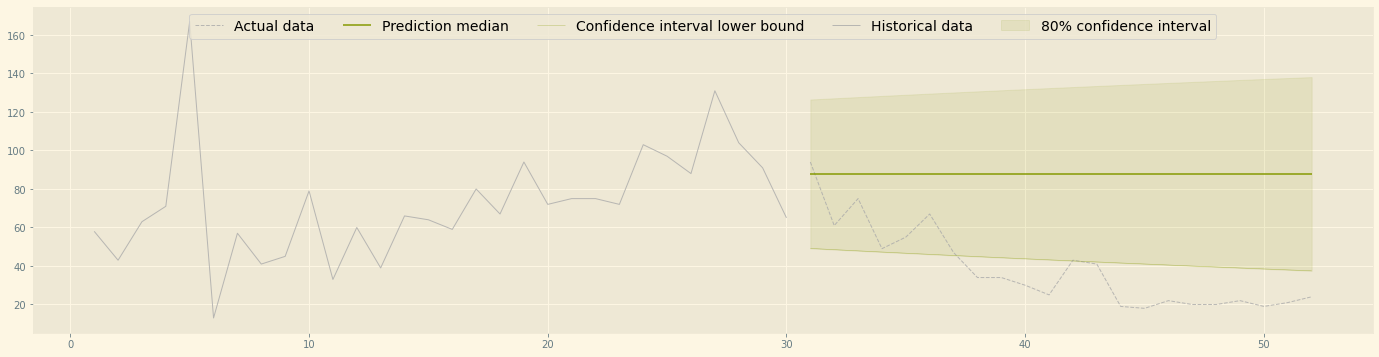

In [97]:
fig = plt.figure(figsize=(24,6))
plt.plot(results_df['actual'], label='Actual data', linewidth=1, color='#AAAAAA', linestyle='--', alpha=0.8)
plt.plot(results_df['p50'], label='Prediction median', color=colors[2], linewidth=1.5)
p10 = results_df['p10']
p90 = results_df['p90']
plt.fill_between(p10.index, p10, p90, color=colors[2], alpha=0.1, label='80% confidence interval')
plt.plot(results_df['p10'], label='Confidence interval lower bound', color=colors[2], linewidth=0.5, alpha=0.5)
plt.plot(actual_train_df.loc[:, 'actual'], label='Historical data', linewidth=1, color='#AAAAAA', alpha=0.8)
plt.legend(fontsize=14, ncol=5, loc='upper center')
plt.show()

# Xét thêm các sản phẩm khác

In [60]:
shop_id = '510068'

print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={'item_id': shop_id}
)
print(forecastResponse)

arn:aws:forecast:eu-west-1:800285456211:forecast/Hanoi_retail_forecast_arima_forecast

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2019-07-29T00:00:00', 'Value': -34.6298828125}, {'Timestamp': '2019-08-05T00:00:00', 'Value': -36.29903030395508}, {'Timestamp': '2019-08-12T00:00:00', 'Value': -37.89989471435547}, {'Timestamp': '2019-08-19T00:00:00', 'Value': -39.44023132324219}, {'Timestamp': '2019-08-26T00:00:00', 'Value': -40.92642593383789}, {'Timestamp': '2019-09-02T00:00:00', 'Value': -42.36381530761719}, {'Timestamp': '2019-09-09T00:00:00', 'Value': -43.75691223144531}, {'Timestamp': '2019-09-16T00:00:00', 'Value': -45.10957336425781}, {'Timestamp': '2019-09-23T00:00:00', 'Value': -46.425132751464844}, {'Timestamp': '2019-09-30T00:00:00', 'Value': -47.70648193359375}, {'Timestamp': '2019-10-07T00:00:00', 'Value': -48.95616149902344}, {'Timestamp': '2019-10-14T00:00:00', 'Value': -50.17640686035156}, {'Timestamp': '2019-10-21T00:00:00', 'Value': -51.369205474853516}, {'Time

In [63]:
item_id = 510068
# Samsung A7
actual_train_df = pd.read_csv(f'{PROCESSED_DATA}/train.csv', names=['timestamp','item_id','actual'], parse_dates=[0])
actual_train_df = actual_train_df[actual_train_df['item_id'] == item_id]
actual_train_df = Format(actual_train_df)
# actual_train_df = formatdataframe(actual_train_df)
actual_test_df = pd.read_csv(f'{PROCESSED_DATA}/test.csv', names=['timestamp','item_id','actual'], parse_dates=[0]) 
actual_test_df = actual_test_df[actual_test_df['item_id'] == item_id]
actual_test_df = Format(actual_test_df)
actual_test_df = actual_test_df.loc[2:]
# actual_test_df
# actual_train_df

In [64]:
predictions_df = dict()
for percentile in ['p10', 'p50', 'p90']:
    predictions_df.update({percentile: pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions'][percentile])})
    predictions_df[percentile]['Timestamp'] = pd.to_datetime(predictions_df[percentile]['Timestamp'])
    predictions_df[percentile].columns = ['Timestamp', percentile]

In [65]:
def FormatDate(data):
    data['week'] = data['Timestamp'].apply(lambda x: x.isocalendar()[1])
    data = data[data['week'] < 53].drop(columns = 'Timestamp')
    return data

results_df = pd.merge(actual_test_df.reset_index(),FormatDate(predictions_df['p10']), how='inner', left_on=['week'], right_on='week')
for percentile in ['p50', 'p90']:
    results_df = pd.merge(results_df, FormatDate(predictions_df[percentile]), how='inner', left_on=['week'], right_on='week')

results_df = results_df[['week', 'actual', 'p10', 'p50', 'p90']]
results_df = results_df.set_index('week')
results_df

,actual,p10,p50,p90
week,,,,
31,3,-34.629883,2.868318,40.366516
32,6,-36.299030,2.868318,42.035664
33,6,-37.899895,2.868318,43.636532
34,1,-39.440231,2.868318,45.176868
35,2,-40.926426,2.868318,46.663063
36,5,-42.363815,2.868318,48.100449
37,12,-43.756912,2.868318,49.493546
38,4,-45.109573,2.868318,50.846210
39,4,-46.425133,2.868318,52.161770


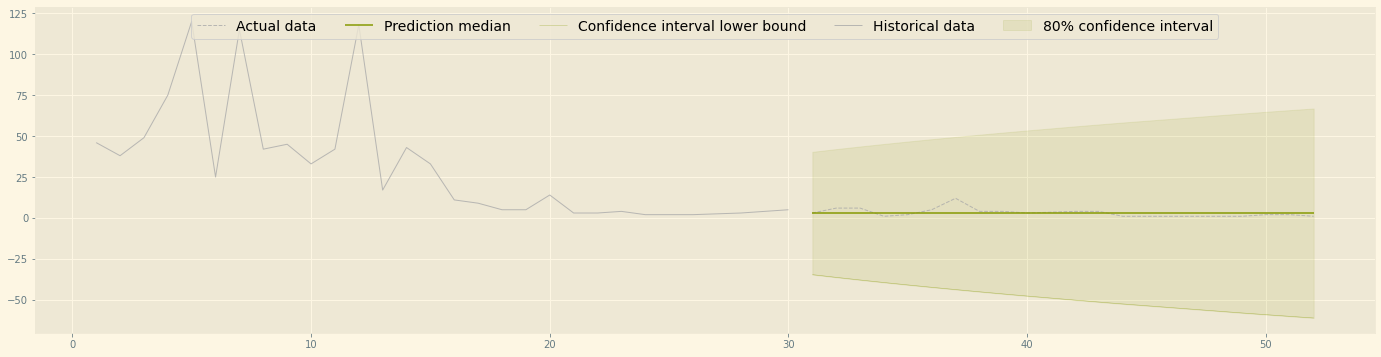

In [66]:
fig = plt.figure(figsize=(24,6))
plt.plot(results_df['actual'], label='Actual data', linewidth=1, color='#AAAAAA', linestyle='--', alpha=0.8)
plt.plot(results_df['p50'], label='Prediction median', color=colors[2], linewidth=1.5)
p10 = results_df['p10']
p90 = results_df['p90']
plt.fill_between(p10.index, p10, p90, color=colors[2], alpha=0.1, label='80% confidence interval')
plt.plot(results_df['p10'], label='Confidence interval lower bound', color=colors[2], linewidth=0.5, alpha=0.5)
plt.plot(actual_train_df.loc[:, 'actual'], label='Historical data', linewidth=1, color='#AAAAAA', alpha=0.8)
plt.legend(fontsize=14, ncol=5, loc='upper center')
plt.show()